In [1]:
import os
import torch
from functools import partial
from torch import nn
import math
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
from IPython import display
import numpy as np
import torch.nn.functional as F
from tqdm.auto import tqdm
import functools
from einops import rearrange, repeat
from scipy.linalg import sqrtm

from scipy.stats import gaussian_kde

from models.mlp import ResNet, CFGResNet, CtrlResNet, CtrlCondResNet
from sdes.forward import uncon_VP_1D
from sdes.backward import uncon_EulerMaruyama, ODE_uncon_EulerMaruyama, EulerMaruyama
from likelihood import get_likelihood_fn

/home/tonyz/anaconda3/lib/python3.11/site-packages/torch/utils/data/dataset.py:348: UserWarning: Length of split at index 1 is 0. This might result in an empty dataset.
  warnings.warn(f"Length of split at index {i} is 0. "


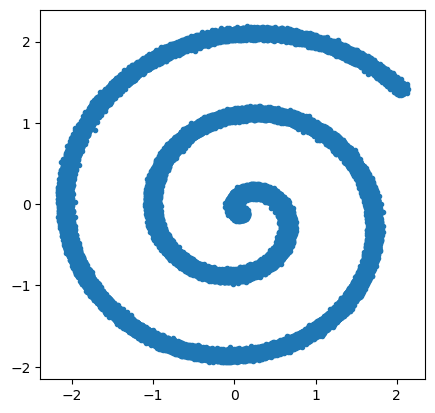

In [2]:
def seed_everything(seed):
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

def data_gen(length):
  t0=5
  k = 1.5
  strength = 0.03
  train_data = torch.zeros((length,2))
  train_param = torch.rand(length)*10-5
  train_data[:, 0]  = 0.2*k*(train_param[:]-t0)*torch.cos(k*(train_param[:]-t0))+strength*torch.randn(length)
  train_data[:, 1]  = 0.2*k*(train_param[:]-t0)*torch.sin(k*(train_param[:]-t0))+strength*torch.randn(length)
  return train_data, train_param

def get_pos_from_rad(rad, k=1.5, t0=5):
  tmp_arr = torch.zeros([rad.shape[0],2])
  tmp_arr[:, 0]  = 0.2*k*(rad-t0)*torch.cos(k*(rad-t0))
  tmp_arr[:, 1]  = 0.2*k*(rad-t0)*torch.sin(k*(rad-t0))
  mu = torch.mean(tmp_arr, dim=0).unsqueeze(0)
  std = torch.std(tmp_arr, dim=0).unsqueeze(0)
  tmp_arr = (tmp_arr - mu) / std
  return tmp_arr.cpu().detach().numpy()

def get_pos_from_single_rad(rad, data_mu, data_std, k=1.5, t0=5):
  tmp_arr = torch.zeros([rad.shape[0],2])
  tmp_arr[:, 0]  = 0.2*k*(rad-t0)*torch.cos(k*(rad-t0))
  tmp_arr[:, 1]  = 0.2*k*(rad-t0)*torch.sin(k*(rad-t0))
  tmp_arr = (tmp_arr - data_mu) / data_std
  return tmp_arr.cpu().detach().numpy()

def swiss_roll_eval(xy_coord, rad, **kwargs):
  data_mu = kwargs.get('data_mu')
  data_std = kwargs.get('data_std')
  if data_mu is None or data_std is None:
    raise ValueError("Both data_mu and data_std must be provided")
  true_xy = get_pos_from_single_rad(rad, data_mu, data_std)
  return torch.tensor(true_xy, device=xy_coord.device) - xy_coord

def loss_fn_vp(model, x, c, beta_min, beta_max, eps=1e-5):
  """The loss function for training score-based generative models VP SDE

  Args:
    model: A PyTorch model instance that represents a
      time-dependent score-based model.
    x: A mini-batch of training data.
    beta_min: hyperparameter defining noise scales
    beta_max: hyperparameter defining noise scales
  """
  random_t = torch.rand(x.shape[0], device=x.device) * (1. - eps) + eps
  z = torch.randn_like(x, device=x.device)
  mu = x*torch.exp(-0.25*random_t**2*(beta_max-beta_min)-0.5*random_t*beta_min)[:, None]
  std = torch.sqrt(1-torch.exp(-0.5*random_t**2*(beta_max-beta_min)-random_t*beta_min))
  perturbed_x = mu + z*std[:, None]
  score = model(perturbed_x, c, random_t)

  loss = torch.mean(torch.sum((score*std[:, None] + z)**2, dim=1))
  #loss = torch.mean(torch.sum((score + z)**2, dim=1))
  return loss

def p_losses(score_model, sde, x0):
    # compute losses (including ELBO, score-matching loss)
    t = torch.rand(x0.shape[0], device=x0.device) * (1. - 1e-5) + 1e-5
    x_perturbed, std, z = sde.forward(x0, t)
    #context_mask = torch.zeros_like(c)
    score_pred = score_model(x_perturbed, t)

    loss_dict = {}

    log_prefix = 'train' 

    # score-mathcing objective function
    score_loss = torch.sum((score_pred*std + z)**2, dim=(1))

    loss_dict.update({f'{log_prefix}/loss_score': score_loss.mean()})

    lamb = sde.g(t)**2
    loss_vlb = lamb*score_loss
    loss_vlb = loss_vlb.mean()
    loss_dict.update({f'{log_prefix}/loss_vlb': loss_vlb})

    loss = score_loss.mean()

    loss_dict.update({f'{log_prefix}/loss': loss})

    return loss, loss_dict

def p_losses_cond(score_model, sde, x0, c, **kwargs):
    # compute losses (including ELBO, score-matching loss)
    t = torch.rand(x0.shape[0], device=x0.device) * (1. - 1e-5) + 1e-5
    x_perturbed, std, z = sde.forward(x0, t)
    #context_mask = torch.zeros_like(c)
    score_pred = score_model(x_perturbed, c, t, **kwargs)

    loss_dict = {}

    log_prefix = 'train' 

    # score-mathcing objective function
    score_loss = torch.sum((score_pred*std + z)**2, dim=(1))

    loss_dict.update({f'{log_prefix}/loss_score': score_loss.mean()})

    lamb = sde.g(t)**2
    loss_vlb = lamb*score_loss
    loss_vlb = loss_vlb.mean()
    loss_dict.update({f'{log_prefix}/loss_vlb': loss_vlb})

    loss = score_loss.mean()

    loss_dict.update({f'{log_prefix}/loss': loss})

    return loss, loss_dict

# calculate frechet inception distance
def fid_metric(act1, act2):
  # calculate mean and covariance statistics
  mu1, sigma1 = act1.mean(axis=0), np.cov(act1, rowvar=False)
  mu2, sigma2 = act2.mean(axis=0), np.cov(act2, rowvar=False)
  # calculate sum squared difference between means
  ssdiff = np.sum((mu1 - mu2)**2.0)
  # calculate sqrt of product between cov
  if np.isnan(sigma1).any() or np.isnan(sigma2).any() or np.isinf(sigma1).any() or np.isinf(sigma2).any():
    print("Invalid values detected in sigma1 or sigma2. Returning NaN for metrics.")
    return (np.nan, np.nan)
  covmean = sqrtm(sigma1.dot(sigma2))
  # check and correct imaginary numbers from sqrt
  if np.iscomplexobj(covmean):
    covmean = covmean.real
  # calculate score
  fid = ssdiff + np.trace(sigma1 + sigma2 - 2.0 * covmean)
  return fid

def get_KLD(samp1=None, dat=None):
    # Load the data
    if samp1 is None and dat is None:
        samp1 = np.loadtxt('samples.out')
        dat = np.loadtxt('true_dat.out')

    # Parameters for the histogram
    bins = np.arange(-4, 4 + 0.16, 0.16)
    hist_range = [[-3, 3], [-3, 3]]
    histogram1, xedges, yedges = np.histogram2d(samp1[:, 0], samp1[:, 1], bins=[bins, bins], range=hist_range, density=True)
    # Calculate the entropy for samp1
    entropy_samp1 = -np.sum(histogram1 * np.log(histogram1 + 1.e-20)) * 0.16 * 0.16

    histogram2, _, _ = np.histogram2d(dat[:, 0], dat[:, 1], bins=[bins, bins], range=hist_range, density=True)
    # Calculate the entropy for true data
    entropy_dat = -np.sum(histogram2 * np.log(histogram2 + 1.e-20)) * 0.16 * 0.16

    # Flatten the histograms for KLD calculation
    flat_pdf_true = histogram2.flatten() + 1.e-20
    flat_pdf_gen = histogram1.flatten() + 1.e-20

    # Calculate the KLD
    KLD = np.sum(flat_pdf_true * np.log(flat_pdf_true / flat_pdf_gen)) * (xedges[1] - xedges[0]) * (yedges[1] - yedges[0])
    print('KLD: ', KLD)
    #plot_distribution(xedges, yedges, histogram1, histogram2, hist_range)
    return KLD, entropy_samp1, entropy_dat

seed_everything(0)
data_type = 'swiss_roll' # 'circle'
#ndim = 2

train_data_length = int(1E6)

xlim_min = -1.5
xlim_max = 2.0
ylim_min = -1.5
ylim_max = 2.0

train_data, _ = data_gen(train_data_length)
data_mu = torch.mean(train_data, dim=0).unsqueeze(0)
data_std = torch.std(train_data, dim=0).unsqueeze(0)
train_data = (train_data - data_mu) / data_std
#train_data = 2*(train_data-torch.min(train_data, dim=0)[0])/(torch.max(train_data,dim=0)[0]-torch.min(train_data, dim=0)[0])-1
train_labels = torch.zeros(train_data_length)
train_set = [
    (train_data[i], train_labels[i]) for i in range(train_data_length)
]
generator = torch.Generator().manual_seed(0)
train_set, val_set = torch.utils.data.random_split(train_set, [1,0], generator=generator)


batch_size = 32
train_loader = torch.utils.data.DataLoader(
    train_set, batch_size=batch_size
)
#val_loader = torch.utils.data.DataLoader(
#    val_set, batch_size=batch_size, shuffle=True
#)

plt.plot(train_data[train_set.indices, 0], train_data[train_set.indices, 1], ".")
#plt.plot(train_data[val_set.indices, 0], train_data[val_set.indices, 1], ".")
#plt.xlim(xlim_min, xlim_max)
#plt.ylim(ylim_min, ylim_max)
plt.gca().set_aspect('equal', adjustable='box')

In [3]:
print(train_data.shape)
#np.savetxt('true_dat.out', train_data)

torch.Size([1000000, 2])


## NN structure

### **Embeddings**

#### why embedding is needed:
https://datascience.stackexchange.com/questions/85855/why-transform-embedding-dimension-in-sin-cos-positional-encoding

A multi-head attention layer of the Transformer architecture performs computations that are position-independent. This means that, if the same inputs are received at two different positions, the attention heads in the layer would return the same value at the two positions.
(Attention module not implemented yet)

#### What should positional embeddings do?
https://harrisonpim.com/blog/understanding-positional-embeddings-in-transformer-models

Unlike word embeddings, the characteristics of positional embeddings aren't emergent from data - they can be deliberately constructed to have certain properties. Concisely, positional embeddings should:

* Be reflective of their distances from one another in the sequence - we should be able to use a distance metric to compare vectors, with positionally similar vectors producing small distances, and positionally distant vectors producing large distances in the vector space we construct.

* Have values bounded between 0 and 1 - we’re using these as inputs to a neural network, so well-bounded values are useful.

* Be invariant to sequence length - the values assigned to each position should be the same, whether the text is long or short.

* Be deterministic - they shouldn't change from one initialisation of a network to another.

### **Feature-wise transformations**

https://distill.pub/2018/feature-wise-transformations/

if self.adaptive_scale:

    scale, shift = params.chunk(2, dim=-1)

    x = nn.functional.silu(torch.addcmul(shift, x, scale+1))

Compared to direct concatenation of feature and embedding, the procedure shown above have equivalent struture in theory and don't have to increase the latent space of the model.

### **ResNet config**

The implemented ResNet emulates the struture of the ResNet used in CV, where the conv2D layer in CV is simply replaced by the linear layer. Each ResNet block is equivalent to have 2 MLP layers and a single layer to process the time embedding.

The first and final linear layers are used to map the input to the dim dimension and to map the dim dimension back to the output dimension, respectively.

### **Normalization**
The implemented normalization is the Affine operator in ResMLP (https://paperswithcode.com/method/affine-operator)

$\text{Aff}_{\alpha,\beta}(x)=Diag(\alpha)x+beta$

where $\alpha,\beta$ are learnable weight parameters (initialize to ones and zeros), the Aff operator does not depend on batch statistics.

## Score-based modeling

Score-based modeling with SDEs relies on a stochastic process which can be reversed to produce samples from a data distribution. The noising process takes samples from the source (data) distribution, and progressively adds noise according to the dynamics of the SDE. The final distribution should be approximately equal to a prior distribution which does not depend on the data.

Samples can then be drawn from the prior, the reverse SDE simulated, and the final sample is from the data distribution

A simple architecture is implemented here to predict the time-dependent score function.

### **SDEs**

#### **Variance Exploding [VE] SDE**
We define our SDE by

$dx = \sigma^t dw \;, \; t \in [0, 1]$

where $w$ is the Weiner process. This SDE defines a noise schedule which exponentially increases in time, similarly to the annealed variance schedule in discrete time.

Solving the SDE, we have the transition kernel

$p_{0t}(x(t)|x(0)) = \mathcal{N}\left ( x(t); x(0), \frac{1}{2\log \sigma}(\sigma^{2t} -1)I \right )$

With large enough $\sigma$, this means that the prior $p(x(t=1))$ approximately does not depend on the data

$\int p_0(y)p_{01}(y(1)|y(0))dy \approx \mathcal{N}(x; 0, \frac{1}{2\log \sigma}(\sigma^2-1)I)$

To sample, we simulate the reverse-time SDE give by

$dx = -\sigma^{2t}s_\theta(x, t)dt + \sigma^tdw$

An Euler-Maruyama sampling step for this is given by

$x_{t-\Delta t} = x_t + \sigma^{2t}s_\theta(x_t,t)\Delta t + \sigma^t\sqrt{\Delta t} z_t$

where $dw$ is replaced with $z\sim \mathcal{N}(0, \sigma^{2t}\Delta t I)$

We define these functions, the loss function, and an Euler-Maruyama sampler below

#### **Variance Preserving [VP] SDE**

This SDE is shown to be equivalent to the denoising-diffusion probabilistic modeling (DDMP) from Ho et al: https://arxiv.org/pdf/2006.11239.pdf

The SDE form is given by

$dx = -\frac{1}{2}\beta(t)xdt + \sqrt{\beta(t)}dw$

where

$\beta(t) = \beta_{min}+t(\beta_{max}-\beta_{min})$

The transition kernel can then be found from Eq. 5.50 and 5.51 in Simo Sarkka and Arno Solin "Applied stochastic differential equations" to be

$p_{0t}(x(t)|x(0)) = \mathcal{N}\left (x(t);x(0)\exp{\left (-\frac{1}{4}t^2(\beta_{max}-\beta_{min})-\frac{1}{2}t\beta_{min} \right )}, I(1-\exp{\left [ -\frac{1}{2}t^2(\beta_{max}-\beta_{min})-t\beta_{min} \right ])} \right)$

and the prior distribution $p(x(t=1))$ is given approimately by

$p(x(t=1))\approx \mathcal{N}(0, I)$

### **Classifier-free guidance**
For the reverse-time SDE, replacing the $\nabla_x \log p(x(t))$ term in score matching loss function gives:

$dx = [f(x,t)-g(t)^2\nabla_x \log p(x(t)|\theta)]dt + g(t)dw$

From the weighted classifier free equation we have:

$\log p(x(t)|\theta)  = \gamma \underbrace{\nabla_x \log p(x(t)|\theta)}_{\text{cond. score}} + (1-\gamma)\underbrace{\nabla_x \log p(x(t))}_{\text{uncond. score}}$

In practice, the unconditional score is obtained by conditioning on 'null':

self.null_emb = nn.Parameter(torch.randn(emb_size))

and $(1-\gamma)$ is treated as the probability of dropping condition during training.

The conditional dim (null class for every input when trained in uncon) is not introduced in this notebook because it was found that adding the dim would reduce the performance.

No saved model weights found or Training=True.
training ...
train data length:  128  last_loss:  0.37823769450187683


Sampling: 100%|██████████| 1000/1000 [05:50<00:00,  2.85iteration/s]


KLD:  1.0486855872683942
Train data size: 128


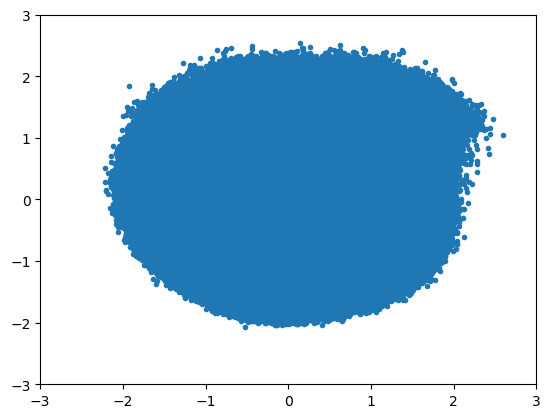

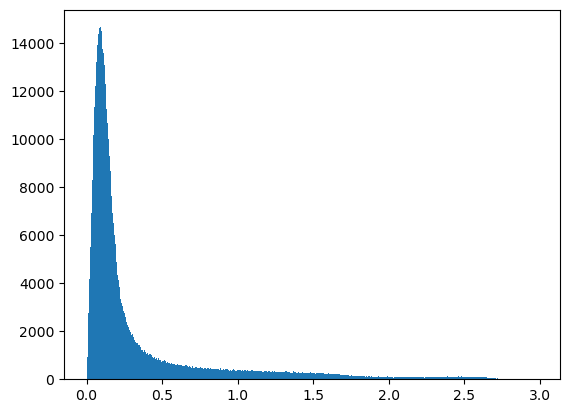

0.34498337
No saved model weights found or Training=True.
training ...
train data length:  256  last_loss:  0.3318121116608381


Sampling: 100%|██████████| 1000/1000 [05:11<00:00,  3.21iteration/s]


KLD:  0.6562846408543974
Train data size: 256


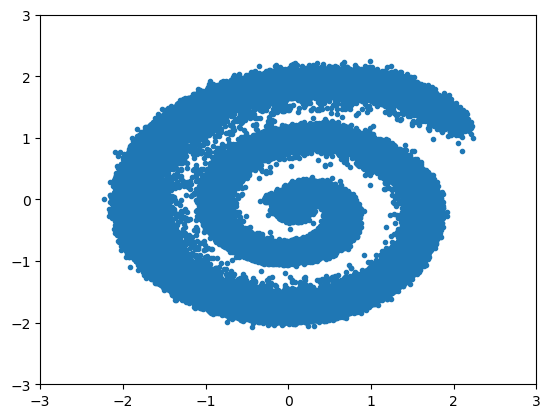

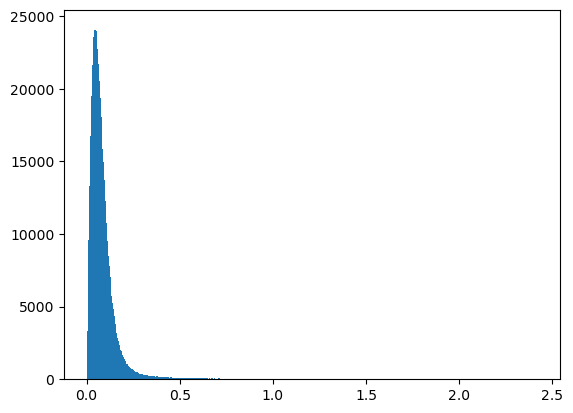

0.088660516
No saved model weights found or Training=True.
training ...
train data length:  512  last_loss:  0.25866940151900053


Sampling: 100%|██████████| 1000/1000 [05:10<00:00,  3.22iteration/s]


KLD:  0.19905423405894104
Train data size: 512


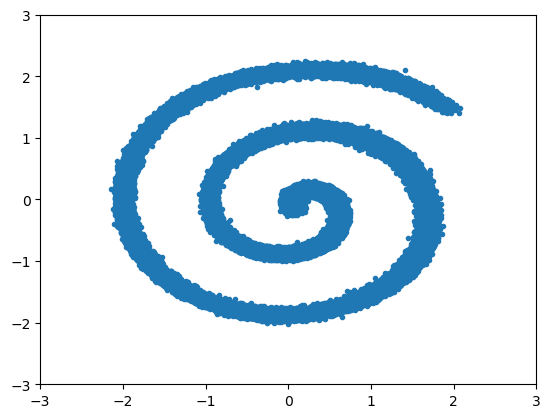

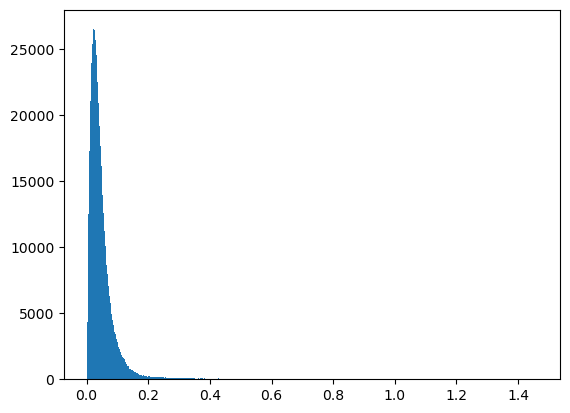

0.050780434
No saved model weights found or Training=True.
training ...
train data length:  1024  last_loss:  0.20943759428337216


Sampling: 100%|██████████| 1000/1000 [05:10<00:00,  3.22iteration/s]


KLD:  0.1435232345813264
Train data size: 1024


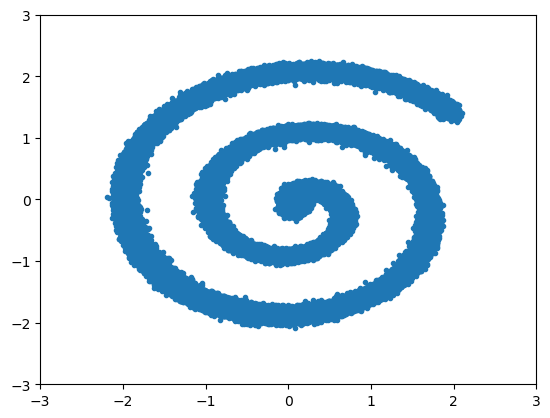

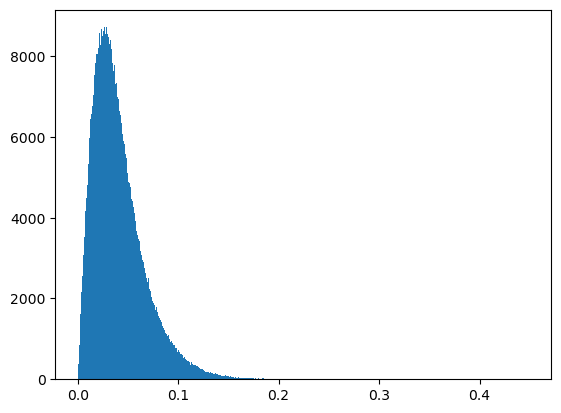

0.040930968
No saved model weights found or Training=True.
training ...
train data length:  2048  last_loss:  0.20768491504713893


Sampling: 100%|██████████| 1000/1000 [05:12<00:00,  3.20iteration/s]


KLD:  0.08672451405372525
Train data size: 2048


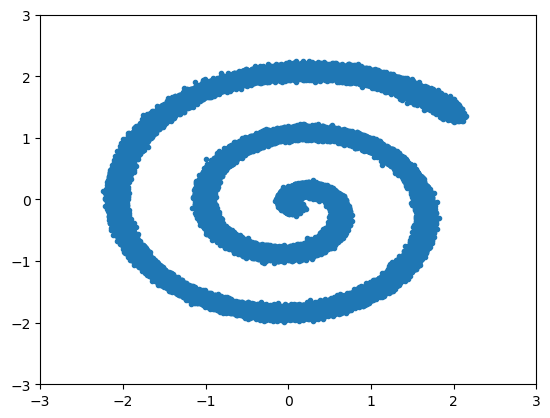

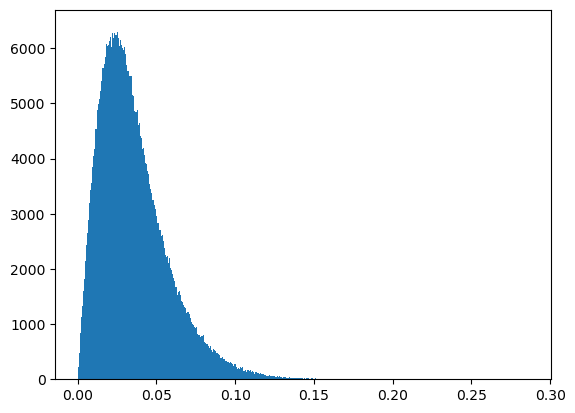

0.035705462
No saved model weights found or Training=True.
training ...
train data length:  4096  last_loss:  0.19387761503458023


Sampling: 100%|██████████| 1000/1000 [05:11<00:00,  3.21iteration/s]


KLD:  0.10860895912194653
Train data size: 4096


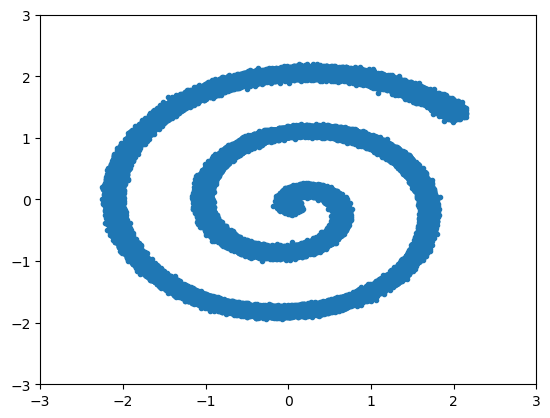

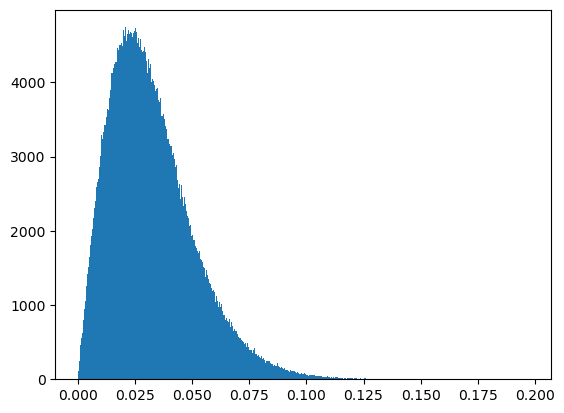

0.03248348
No saved model weights found or Training=True.
training ...
train data length:  8192  last_loss:  0.17111736930382904


Sampling: 100%|██████████| 1000/1000 [05:11<00:00,  3.21iteration/s]


KLD:  0.019479998066679934
Train data size: 8192


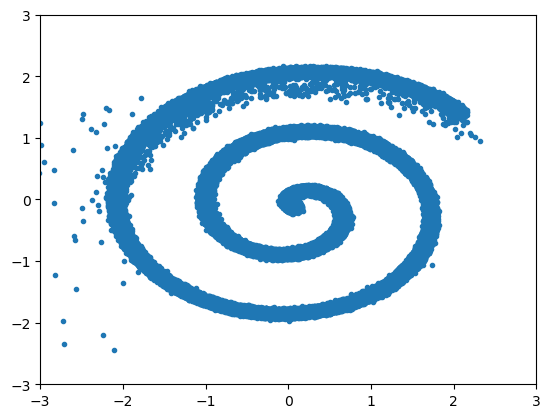

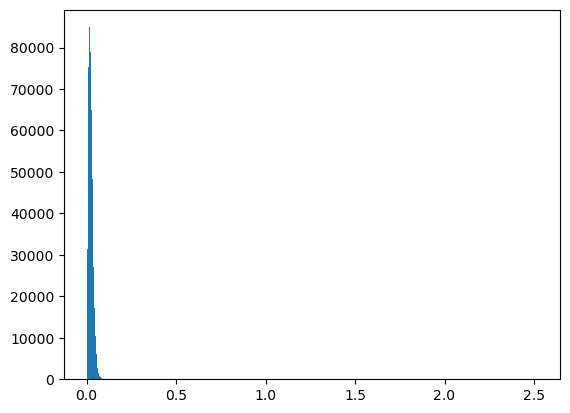

0.022783697


In [4]:
seed_everything(0)
# optimization
learning_rate = 1e-4
num_epochs = 500

beta_min = 1e-4 # for SDE noise [VP]
beta_max = 0.5 # for SDE noise [VP]
cond_scale =1
rescaled_phi = 0

device='cuda'
train_len_vals = np.array([128, 256, 512, 1024, 2048, 4096, 8192])
sample_size = int(1E6)
orig_sample, orig_labels = data_gen(sample_size)
data_mu = torch.mean(orig_sample, dim=0).unsqueeze(0)
data_std = torch.std(orig_sample, dim=0).unsqueeze(0)
orig_sample = (orig_sample - data_mu) / data_std
last_loss_values = []
fid_values = []
avg_nll_values = []
KLD_arr = []
H_gen_arr = []
H_true_arr = []

Training =True

for train_data_length in train_len_vals:
    seed_everything(0)
    train_data, train_labels = data_gen(train_data_length)
    data_mu = torch.mean(train_data, dim=0).unsqueeze(0)
    data_std = torch.std(train_data, dim=0).unsqueeze(0)
    train_data = (train_data - data_mu) / data_std
    #train_data = 2*(train_data-torch.min(train_data, dim=0)[0])/(torch.max(train_data,dim=0)[0]-torch.min(train_data, dim=0)[0])-1
    train_set = [
        (train_data[i], train_labels[i]) for i in range(train_data_length)
    ]
    generator = torch.Generator().manual_seed(0)
    train_set, val_set = torch.utils.data.random_split(train_set, [1,0], generator=generator)

    batch_size = 32
    train_loader = torch.utils.data.DataLoader(
        train_set, batch_size=batch_size
    )

    vp = uncon_VP_1D(beta_min, beta_max)

    model = CFGResNet(2, 2, cond_size=1, model_dim=128,
                    dim_mult=[1,1,1,1,1,1], dim_mult_emb=1, num_blocks=2,
                    dropout=0, emb_type="sinusoidal", dim_mult_time=1, 
                    dim_mult_cond=1, cond_drop_prob=0, adaptive_scale=True, skip_scale=1.0, affine=True)

    file_path = f'mdl_weights/uncon_train_len_{train_data_length}.pth'

    if os.path.exists(file_path) and not Training:
        model.load_state_dict(torch.load(file_path))
        print("Model weights loaded successfully, computing last epoch loss.")
        model.train()
        model.to(device)

        optimizer = torch.optim.Adam(
                model.parameters(),
                lr=learning_rate,
            )
        for epoch in range(num_epochs):
            model.train()
            avg_loss = 0.
            num_items = 0

            for step, batch in enumerate(train_loader):
                x = batch[0]
                c = batch[1]
                x = x.to(device)
                c = c.to(device)
                loss,_ = p_losses_cond(model, vp, x, c)
                
                #optimizer.zero_grad()
                #loss.backward()
                #optimizer.step()
                num_items += x.shape[0]
                avg_loss += loss.item() * x.shape[0]
    else:
        print("No saved model weights found or Training=True.")
        model.train()
        model.to(device)

        optimizer = torch.optim.Adam(
                model.parameters(),
                lr=learning_rate,
            )

        global_step = 0
        frames = []
        loss_v = []
        loss_avg = []
        #val_loss_avg = []

        #tqdm_epoch = tqdm.notebook.trange(num_epochs)
        best_val_loss = float('inf')
        save_path = './model.pth' 
        print('training ...')
        for epoch in range(num_epochs):
            model.train()
            avg_loss = 0.
            num_items = 0

            for step, batch in enumerate(train_loader):
                x = batch[0]
                c = batch[1]
                x = x.to(device)
                c = c.to(device)
                loss,_ = p_losses_cond(model, vp, x, c)
                
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                avg_loss += loss.item() * x.shape[0]
                num_items += x.shape[0]
                loss_v.append(loss.item())
                loss_avg.append(avg_loss / num_items)
            # Print the averaged training loss so far.
            #if epoch % output_step == 0 or epoch == num_epochs - 1:
        torch.save(model.state_dict(), 'mdl_weights/uncon_train_len'+'_'+str(train_data_length)+'.pth')
        print('train data length: ', train_data_length, ' last_loss: ', avg_loss / num_items)

    model.eval()
    last_loss = avg_loss / num_items
    vp_sampler = EulerMaruyama(1000, 1e-5, 0, sample_size)
    #vp_ode_sampler = ODE_uncon_EulerMaruyama(1000, 1e-5, 10000, 1e-5, 1e-5)
    test_cond = torch.rand(sample_size, device=device)*10-5
    with torch.no_grad():
        samples, _ = vp_sampler(model, vp, (sample_size, 2),  device, c=test_cond,
                                 cond_scale=cond_scale, rescaled_phi=rescaled_phi, cond_drop_prob=0)
    #samples, _ = vp_ode_sampler(model, vp, train_data.shape, device)
    samples = samples.detach().cpu().numpy()
    fid = fid_metric(samples, orig_sample.detach().cpu().numpy())
    inverse_scaler = 1 # dummy param
    #likelihood_fn = get_likelihood_fn(vp, inverse_scaler)
    #nll = likelihood_fn(model, orig_sample.to(device))[0]
    #avg_nll = np.mean(nll.detach().cpu().numpy())
    '''
    nll_total = 0
    process_batch_size = 100000
    for i in range(0, orig_sample.size(0), process_batch_size):
        batch = orig_sample[i:i + process_batch_size].to(device)  
        batch_nll = likelihood_fn(model, batch)[0]  
        nll_total += batch_nll.sum().item()  
    # Calculate the average NLL
    avg_nll = nll_total / orig_sample.size(0)
    '''
    
    last_loss_values.append(last_loss)
    fid_values.append(fid)
    #avg_nll_values.append(avg_nll)
    kld, H_gen, H_true = get_KLD(samp1=samples, dat=orig_sample.detach().cpu().numpy())
    KLD_arr.append(kld)
    H_gen_arr.append(H_gen)
    H_true_arr.append(H_true)

    print('Train data size:', train_data_length)
    plt.plot(samples[:,0], samples[:,1], ".")
    plt.xlim((-3,3))
    plt.ylim((-3,3))
    plt.show()
    true_pos = get_pos_from_rad(test_cond)
    avg_err = np.mean(np.abs(samples-true_pos), axis=1)
    plt.hist(avg_err, bins=1000)
    plt.show()
    print(np.mean(avg_err))

The sampling diagram shows the distribution of the 1E6 sampling points. The histogram shows for each generated sampling points, how far they deviate from the true (x,y) position given the $\theta$. The MAE(L1-Norm) is printed.

Using the affine layer as normalization can help to suppress the occurence of extreme outlier (drifing to a distance of ~10000)

Analyzing the approximation of distribution: $Var(kX)=k^2 Var(X)$, since noises for x & y are independent, the variance of the combined distribution would be the summation of the two. Given k=0.03, the true variance of the distribution of deviation in distance is 0.0009*2=0.0018

In [5]:
import pandas as pd

results_df = pd.DataFrame({
    'data_len': train_len_vals,
    'beta_max': np.repeat(beta_max, len(train_len_vals)),
    'last_loss': last_loss_values[-len(train_len_vals):],
    'fid': fid_values[-len(train_len_vals):],
    #'avg_nll': avg_nll_values[-len(train_len_vals):],
    'KLD': KLD_arr[-len(train_len_vals):],
    'H Gen': H_gen_arr[-len(train_len_vals):],
    'H True': H_true_arr[-len(train_len_vals):]
})

print(results_df)

   data_len  beta_max  last_loss       fid       KLD     H Gen    H True
0       128       0.5   0.378238  0.045705  1.048686  1.831942  1.218089
1       256       0.5   0.331812  0.006545  0.656285  1.472938  1.218089
2       512       0.5   0.258669  0.002993  0.199054  1.235575  1.218089
3      1024       0.5   0.209438  0.001321  0.143523  1.328861  1.218089
4      2048       0.5   0.207685  0.000574  0.086725  1.300578  1.218089
5      4096       0.5   0.193878  0.000701  0.108609  1.276517  1.218089
6      8192       0.5   0.171117  0.000021  0.019480  1.226386  1.218089


In [40]:
try:
    model = CFGResNet(2, 2, cond_size=1, model_dim=128,
                dim_mult=[1,1,1,1,1,1], dim_mult_emb=1, num_blocks=2,
                dropout=0, emb_type="sinusoidal", dim_mult_time=1, 
                dim_mult_cond=1, cond_drop_prob=0, adaptive_scale=True, skip_scale=1.0, affine=True)
    model.load_state_dict(torch.load('mdl_weights/uncon_train_len_8192.pth'))
    model = model.to(device)
except:
    pass
model.eval()
last_loss = avg_loss / num_items
vp_sampler = EulerMaruyama(1000, 1e-5, 0, sample_size)
#vp_ode_sampler = ODE_uncon_EulerMaruyama(1000, 1e-5, 10000, 1e-5, 1e-5)
test_sample_size = 10000
test_cond = torch.ones(test_sample_size, device=device)*0
true_pos = get_pos_from_single_rad(test_cond[0].reshape(1,1), data_mu, data_std)
with torch.no_grad():
    samples, _ = vp_sampler(model, vp, (test_sample_size, 2),  device, c=test_cond)
#samples, _ = vp_ode_sampler(model, vp, train_data.shape, device)
samples = samples.detach().cpu().numpy()
samples_var = np.var(samples, axis=0)
print('Variance in x and y: ', samples_var)
err_arr = samples-true_pos
print('Variance of 2D distribution: ', np.var(np.sum(err_arr,axis=1)))
print('True variance for k=0.03: 0.0018')

Sampling: 100%|██████████| 1000/1000 [00:02<00:00, 363.79iteration/s]

Variance in x and y:  [0.00110765 0.00072148]
Variance of 2D distribution:  0.0018387669
True variance for k=0.03: 0.0018


### **Control Net**

The idea of ControlNet is to freeze the pretrained unconditional model and
connect it to a smaller trainable model which will incorporate the conditional information. The conditional portion of the model to be trained is initialized with special zero-convolution layers such that the model will produce unhindered unconditional samples at the onset of trainin.

For 1D data, the Control Net is implemented as a parallel ResMLP-like struture but with less ResNet Blocks/MLP layers.

During training, the unconditional model parameters are frozen. The conditional augmentation is trained using a very similar objective function to score matching equation with the main exception that the conditional score function approximation $s_{\phi,\psi}(x(t), t, \theta)$ contains non-trainable parameters $\phi$ and trainable parameters $\psi$. The training objective therefore becomes 

$\min_\psi \mathbb{E}_t \left [\lambda(t)\mathbb{E}_{p(x(0),\theta)p(x(t)|x(0))}[||s_{\phi,\psi}(x(t), t, \theta) - \nabla_{x(t)}\log p(x(t)|x(0))||_2^2] \right ]$

No saved model weights found or Training=True.
training ...
train data length:  128  last_loss:  1.4875580370426178
training ...
train data length:  128  last_loss:  1.2436466664075851


Sampling: 100%|██████████| 1000/1000 [07:04<00:00,  2.35iteration/s]


KLD:  1.4087595434199742
Train data size: 128


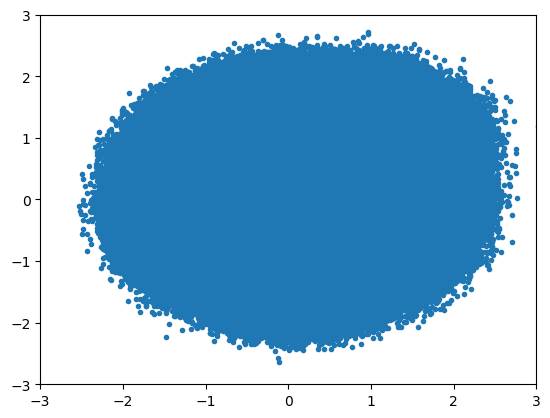

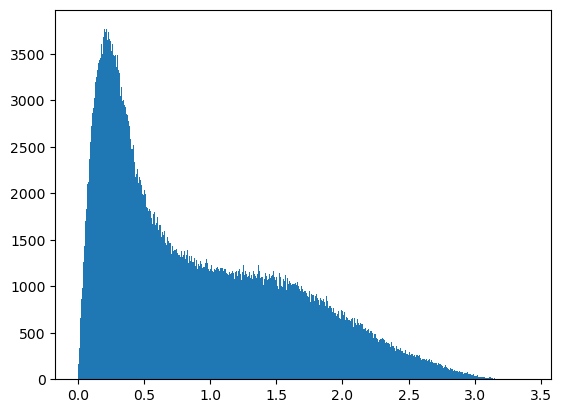

0.91341174
No saved model weights found or Training=True.
training ...
train data length:  256  last_loss:  1.5338092669844627
training ...
train data length:  256  last_loss:  0.9298535957932472


Sampling: 100%|██████████| 1000/1000 [07:02<00:00,  2.37iteration/s]


KLD:  0.7926089496359642
Train data size: 256


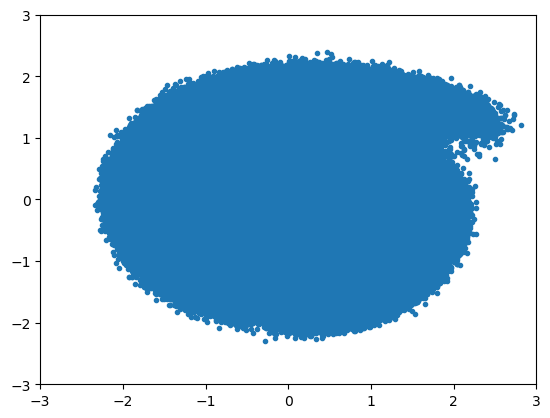

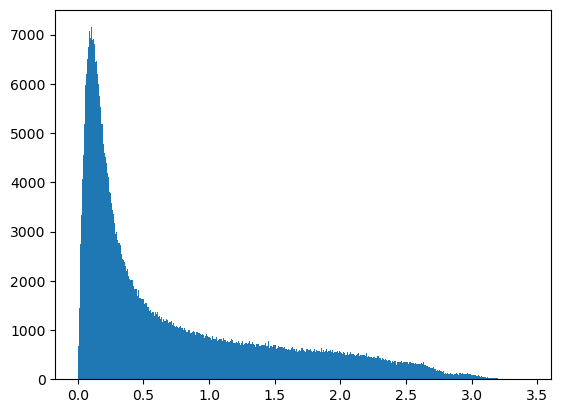

0.7455515
No saved model weights found or Training=True.
training ...
train data length:  512  last_loss:  1.5049683898687363
training ...
train data length:  512  last_loss:  0.5252177752554417


Sampling: 100%|██████████| 1000/1000 [10:40<00:00,  1.56iteration/s]


KLD:  0.46219768107062165
Train data size: 512


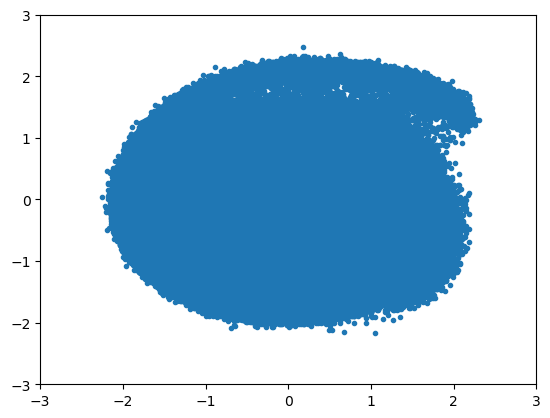

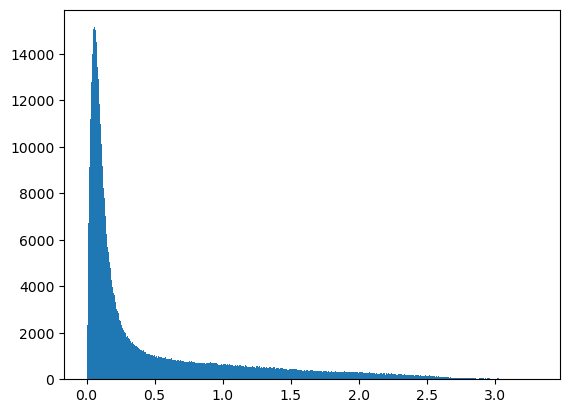

0.48227572
No saved model weights found or Training=True.
training ...
train data length:  1024  last_loss:  1.4216755367815495
training ...
train data length:  1024  last_loss:  0.37300170632079244


Sampling: 100%|██████████| 1000/1000 [07:00<00:00,  2.38iteration/s]


KLD:  0.2752892567398858
Train data size: 1024


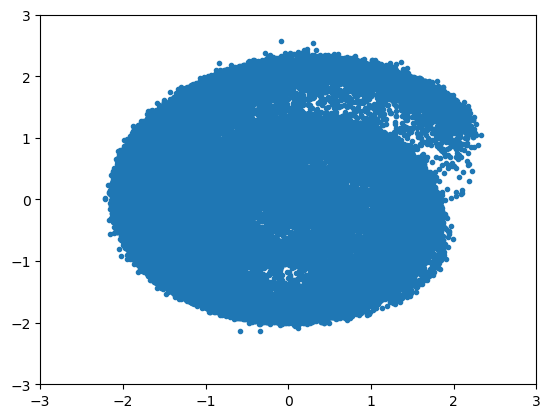

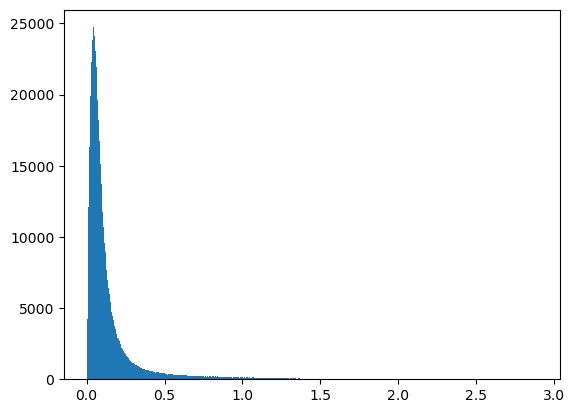

0.14261855
No saved model weights found or Training=True.
training ...
train data length:  2048  last_loss:  1.4008783427998424
training ...
train data length:  2048  last_loss:  0.24605158797930926


Sampling: 100%|██████████| 1000/1000 [07:05<00:00,  2.35iteration/s]


KLD:  0.15288132796047973
Train data size: 2048


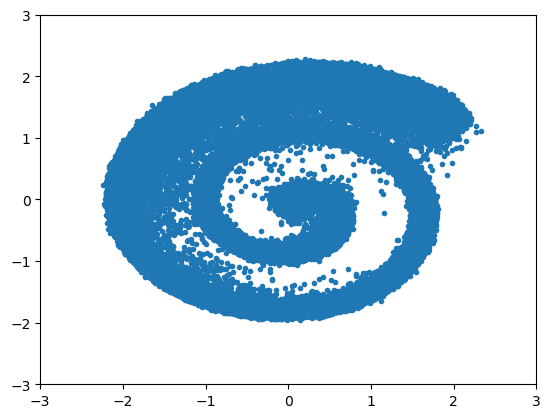

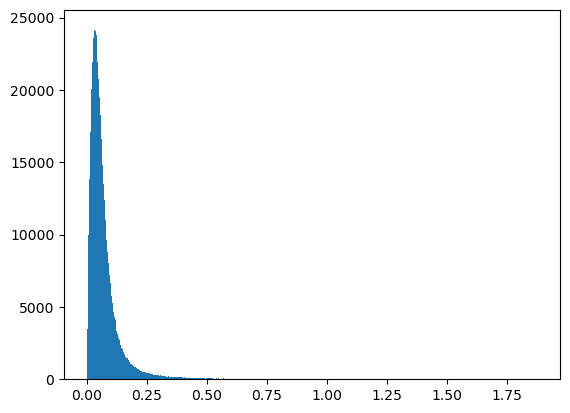

0.07217915
No saved model weights found or Training=True.
training ...
train data length:  4096  last_loss:  1.3917150744237006
training ...
train data length:  4096  last_loss:  0.20538096147356555


Sampling: 100%|██████████| 1000/1000 [06:59<00:00,  2.38iteration/s]


KLD:  0.1304539331756605
Train data size: 4096


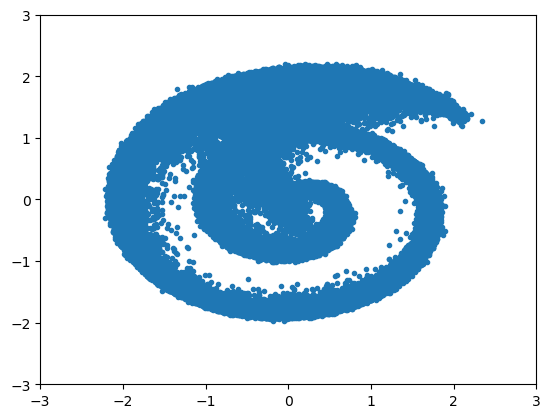

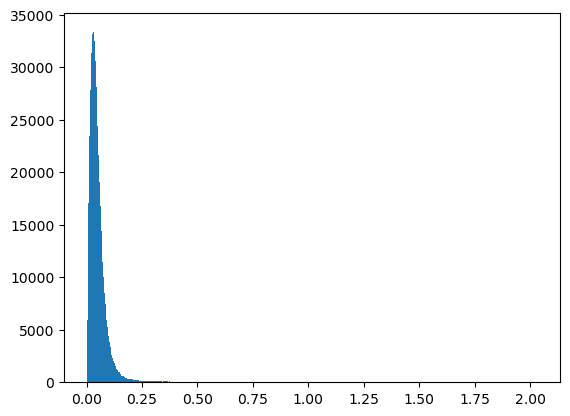

0.05873579
No saved model weights found or Training=True.
training ...
train data length:  8192  last_loss:  1.3859783553052694
training ...
train data length:  8192  last_loss:  0.1909193428218714


Sampling: 100%|██████████| 1000/1000 [07:01<00:00,  2.37iteration/s]


KLD:  0.033659584958305906
Train data size: 8192


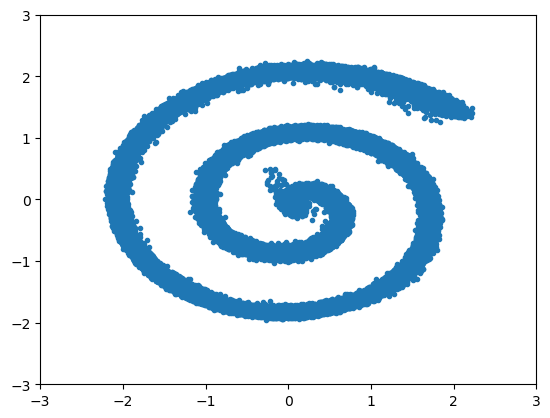

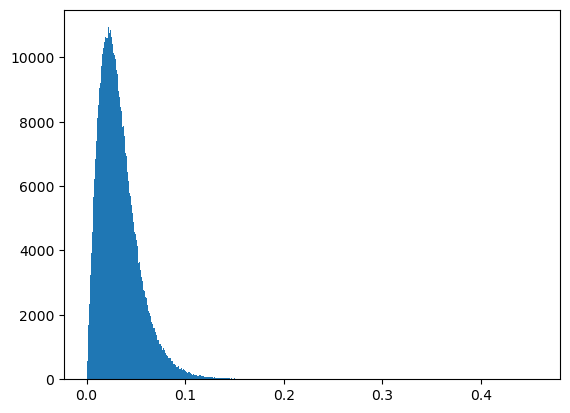

0.032974984


In [4]:
seed_everything(0)
# optimization
learning_rate = 1e-4
num_epochs = 500

beta_min = 1e-4 # for SDE noise [VP]
beta_max = 0.5 # for SDE noise [VP]
cond_scale =1
rescaled_phi = 0

device='cuda'
train_len_vals = np.array([128, 256, 512, 1024, 2048, 4096, 8192])
sample_size = int(1E6)
orig_sample, orig_labels = data_gen(sample_size)
data_mu = torch.mean(orig_sample, dim=0).unsqueeze(0)
data_std = torch.std(orig_sample, dim=0).unsqueeze(0)
orig_sample = (orig_sample - data_mu) / data_std
last_loss_values = []
fid_values = []
avg_nll_values = []
KLD_arr = []
H_gen_arr = []
H_true_arr = []

Training =True

for train_data_length in train_len_vals:
    seed_everything(0)
    train_data, train_labels = data_gen(train_data_length)
    data_mu = torch.mean(train_data, dim=0).unsqueeze(0)
    data_std = torch.std(train_data, dim=0).unsqueeze(0)
    train_data = (train_data - data_mu) / data_std
    #train_data = 2*(train_data-torch.min(train_data, dim=0)[0])/(torch.max(train_data,dim=0)[0]-torch.min(train_data, dim=0)[0])-1
    train_set = [
        (train_data[i], train_labels[i]) for i in range(train_data_length)
    ]
    generator = torch.Generator().manual_seed(0)
    train_set, val_set = torch.utils.data.random_split(train_set, [1,0], generator=generator)

    batch_size = 32
    train_loader = torch.utils.data.DataLoader(
        train_set, batch_size=batch_size
    )

    vp = uncon_VP_1D(beta_min, beta_max)

    model = CtrlResNet(2, 2, 1,model_dim=128, dim_mult=[1,1,1,1,1,1], 
                    dim_mult_emb=1, num_blocks=2, dropout=0, 
                    emb_type="sinusoidal", dim_mult_time=1, 
                    dim_mult_cond=1, adaptive_scale=True, skip_scale=1.0, affine=True)

    file_path = f'mdl_weights/ctrl_train_len_{train_data_length}.pth'

    if os.path.exists(file_path) and not Training:
        model.load_state_dict(torch.load(file_path))
        print("Model weights loaded successfully, computing last epoch loss.")
        model.train()
        model.to(device)

        optimizer = torch.optim.Adam(
                model.parameters(),
                lr=learning_rate,
            )
        for epoch in range(num_epochs):
            model.train()
            avg_loss = 0.
            num_items = 0

            for step, batch in enumerate(train_loader):
                x = batch[0]
                c = batch[1]
                x = x.to(device)
                c = c.to(device)
                loss,_ = p_losses_cond(model, vp, x, c)
                
                #optimizer.zero_grad()
                #loss.backward()
                #optimizer.step()
                num_items += x.shape[0]
                avg_loss += loss.item() * x.shape[0]
    else:
        print("No saved model weights found or Training=True.")
        # for training of the uncon model, lock the control net
        for name, param in model.named_parameters():
            if 'ctrl' in name:
                param.requires_grad = False

        model.train()
        model.to(device)

        optimizer = torch.optim.Adam(
                model.parameters(),
                lr=learning_rate,
            )

        global_step = 0
        frames = []
        loss_v = []
        loss_avg = []
        #val_loss_avg = []

        #tqdm_epoch = tqdm.notebook.trange(num_epochs)
        best_val_loss = float('inf')
        save_path = './model.pth' 
        print('training ...')
        for epoch in range(num_epochs):
            model.train()
            avg_loss = 0.
            num_items = 0

            for step, batch in enumerate(train_loader):
                x = batch[0]
                c = batch[1]
                x = x.to(device)
                c = c.to(device)
                loss,_ = p_losses_cond(model, vp, x, c, controlnet=False)
                
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                avg_loss += loss.item() * x.shape[0]
                num_items += x.shape[0]
        print('train data length: ', train_data_length, ' last_loss: ', avg_loss / num_items)

        # for training of the control net, lock the uncon model
        for name, param in model.named_parameters():
            if 'ctrl' in name:
                param.requires_grad = True
            else:
                param.requires_grad = False

        best_val_loss = float('inf')
        save_path = './model.pth' 
        print('training ...')
        optimizer = torch.optim.Adam(
                model.parameters(),
                lr=learning_rate,
            )
        for epoch in range(num_epochs):
            model.train()
            avg_loss = 0.
            num_items = 0

            for step, batch in enumerate(train_loader):
                x = batch[0]
                c = batch[1]
                x = x.to(device)
                c = c.to(device)
                loss,_ = p_losses_cond(model, vp, x, c, controlnet=True)
                
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                avg_loss += loss.item() * x.shape[0]
                num_items += x.shape[0]
                loss_v.append(loss.item())
                loss_avg.append(avg_loss / num_items)
            # Print the averaged training loss so far.
            #if epoch % output_step == 0 or epoch == num_epochs - 1:
        torch.save(model.state_dict(), 'mdl_weights/ctrl_train_len'+'_'+str(train_data_length)+'.pth')
        print('train data length: ', train_data_length, ' last_loss: ', avg_loss / num_items)

    model.eval()
    last_loss = avg_loss / num_items
    vp_sampler = EulerMaruyama(1000, 1e-5, 0, sample_size)
    #vp_ode_sampler = ODE_uncon_EulerMaruyama(1000, 1e-5, 10000, 1e-5, 1e-5)
    test_cond = torch.rand(sample_size, device=device)*10-5
    with torch.no_grad():
        samples, _ = vp_sampler(model, vp, (sample_size, 2),  device, c=test_cond,
                                controlnet=True)
    #samples, _ = vp_ode_sampler(model, vp, train_data.shape, device)
    samples = samples.detach().cpu().numpy()
    fid = fid_metric(samples, orig_sample.detach().cpu().numpy())
    inverse_scaler = 1 # dummy param
    #likelihood_fn = get_likelihood_fn(vp, inverse_scaler)
    #nll = likelihood_fn(model, orig_sample.to(device))[0]
    #avg_nll = np.mean(nll.detach().cpu().numpy())
    '''
    nll_total = 0
    process_batch_size = 100000
    for i in range(0, orig_sample.size(0), process_batch_size):
        batch = orig_sample[i:i + process_batch_size].to(device)  
        batch_nll = likelihood_fn(model, batch)[0]  
        nll_total += batch_nll.sum().item()  
    # Calculate the average NLL
    avg_nll = nll_total / orig_sample.size(0)
    '''
    
    last_loss_values.append(last_loss)
    fid_values.append(fid)
    #avg_nll_values.append(avg_nll)
    kld, H_gen, H_true = get_KLD(samp1=samples, dat=orig_sample.detach().cpu().numpy())
    KLD_arr.append(kld)
    H_gen_arr.append(H_gen)
    H_true_arr.append(H_true)

    print('Train data size:', train_data_length)
    plt.plot(samples[:,0], samples[:,1], ".")
    plt.xlim((-3,3))
    plt.ylim((-3,3))
    plt.show()
    true_pos = get_pos_from_rad(test_cond)
    avg_err = np.mean(np.abs(samples-true_pos), axis=1)
    plt.hist(avg_err, bins=1000)
    plt.show()
    print(np.mean(avg_err))

In [6]:
import pandas as pd

results_df = pd.DataFrame({
    'data_len': train_len_vals,
    'beta_max': np.repeat(beta_max, len(train_len_vals)),
    'last_loss': last_loss_values[-len(train_len_vals):],
    'fid': fid_values[-len(train_len_vals):],
    #'avg_nll': avg_nll_values[-len(train_len_vals):],
    'KLD': KLD_arr[-len(train_len_vals):],
    'H Gen': H_gen_arr[-len(train_len_vals):],
    'H True': H_true_arr[-len(train_len_vals):]
})

print(results_df)

   data_len  beta_max  last_loss       fid       KLD     H Gen    H True
0       128       0.5   1.243647  0.022355  1.408760  2.510148  1.218089
1       256       0.5   0.929854  0.025974  0.792609  2.132911  1.218089
2       512       0.5   0.525218  0.038295  0.462198  1.864715  1.218089
3      1024       0.5   0.373002  0.007360  0.275289  1.621072  1.218089
4      2048       0.5   0.246052  0.002648  0.152881  1.439137  1.218089
5      4096       0.5   0.205381  0.001789  0.130454  1.407312  1.218089
6      8192       0.5   0.190919  0.000112  0.033660  1.264182  1.218089


In [41]:
try:
    model = CtrlResNet(2, 2, 1,model_dim=128, dim_mult=[1,1,1,1,1,1], 
                dim_mult_emb=1, num_blocks=2, dropout=0, 
                emb_type="sinusoidal", dim_mult_time=1, 
                dim_mult_cond=1, adaptive_scale=True, skip_scale=1.0, affine=True)
    model.load_state_dict(torch.load('mdl_weights/ctrl_train_len_8192.pth'))
    model = model.to(device)
except:
    pass
model.eval()
last_loss = avg_loss / num_items
vp_sampler = EulerMaruyama(1000, 1e-5, 0, sample_size)
#vp_ode_sampler = ODE_uncon_EulerMaruyama(1000, 1e-5, 10000, 1e-5, 1e-5)
test_sample_size = 10000
test_cond = torch.ones(test_sample_size, device=device)*0
true_pos = get_pos_from_single_rad(test_cond[0].reshape(1,1), data_mu, data_std)
with torch.no_grad():
    samples, _ = vp_sampler(model, vp, (test_sample_size, 2),  device, c=test_cond,
                            controlnet=True)
#samples, _ = vp_ode_sampler(model, vp, train_data.shape, device)
samples = samples.detach().cpu().numpy()
samples_var = np.var(samples, axis=0)
print('Variance in x and y: ', samples_var)
err_arr = samples-true_pos
print('Variance of 2D distribution: ', np.var(np.sum(err_arr,axis=1)))
print('True variance for k=0.03: 0.0018')

Sampling: 100%|██████████| 1000/1000 [00:03<00:00, 291.14iteration/s]

Variance in x and y:  [0.00181955 0.00109161]
Variance of 2D distribution:  0.0031555507
True variance for k=0.03: 0.0018


No saved model weights found or Training=True.
training ...
train data length:  128  last_loss:  0.3867906332015991
training ...
train data length:  128  last_loss:  0.4304932430386543


Sampling: 100%|██████████| 1000/1000 [10:14<00:00,  1.63iteration/s]


KLD:  0.9538954764477211
Train data size: 128


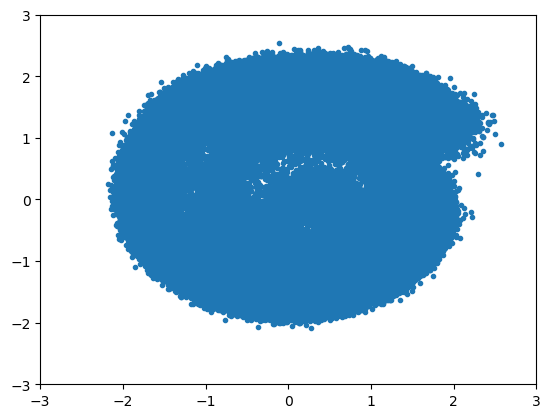

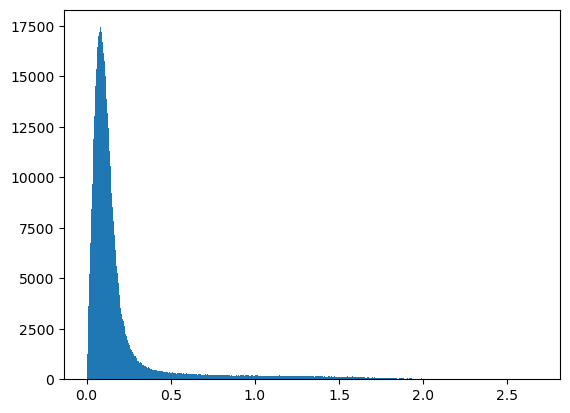

0.20527567
No saved model weights found or Training=True.
training ...
train data length:  256  last_loss:  0.36974125541746616
training ...
train data length:  256  last_loss:  0.28660173155367374


Sampling: 100%|██████████| 1000/1000 [07:35<00:00,  2.19iteration/s]


KLD:  0.7177409776814031
Train data size: 256


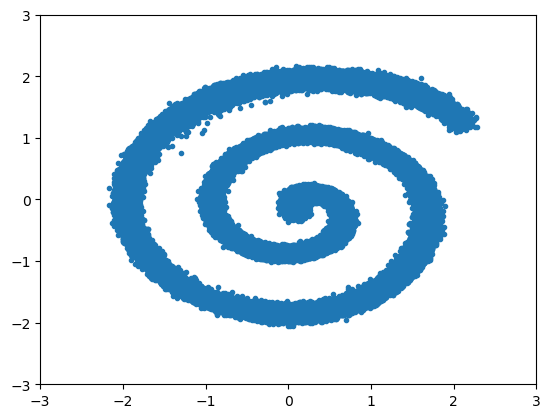

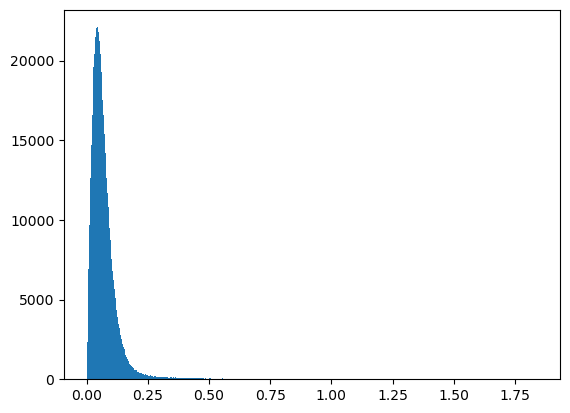

0.072404556
No saved model weights found or Training=True.
training ...
train data length:  512  last_loss:  0.2523502786643803
training ...
train data length:  512  last_loss:  0.15032151201739907


Sampling: 100%|██████████| 1000/1000 [08:31<00:00,  1.96iteration/s]


KLD:  0.38725191889602
Train data size: 512


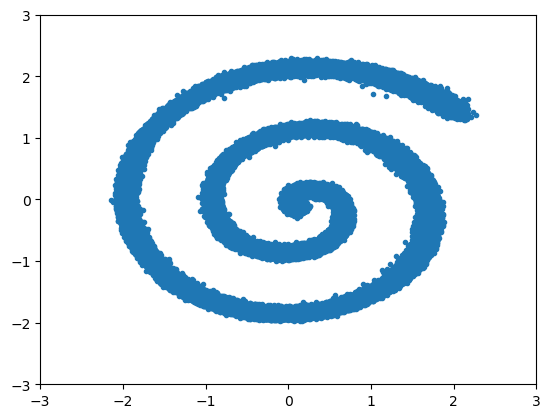

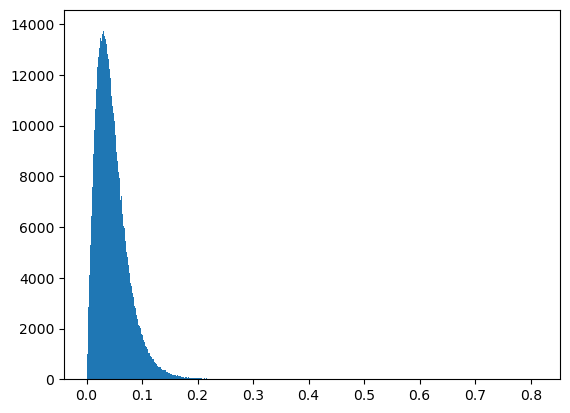

0.04634941
No saved model weights found or Training=True.
training ...
train data length:  1024  last_loss:  0.2080984611529857
training ...
train data length:  1024  last_loss:  0.17031520302407444


Sampling: 100%|██████████| 1000/1000 [07:53<00:00,  2.11iteration/s]


KLD:  0.16649509392605724
Train data size: 1024


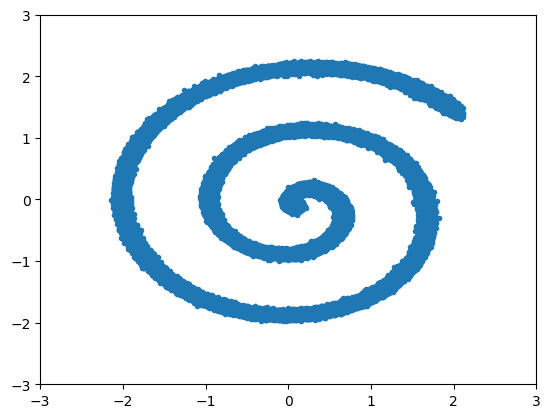

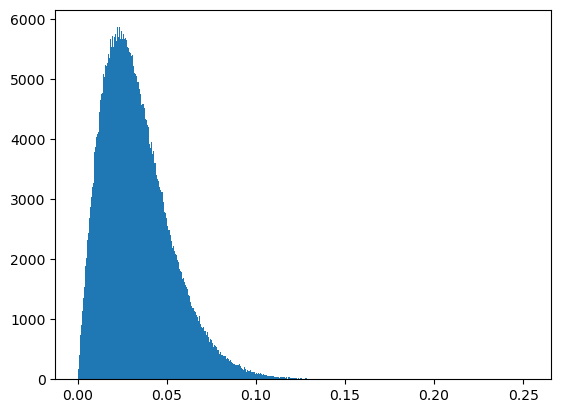

0.03334926
No saved model weights found or Training=True.
training ...
train data length:  2048  last_loss:  0.2133262690040283
training ...
train data length:  2048  last_loss:  0.15329330178792588


Sampling: 100%|██████████| 1000/1000 [07:46<00:00,  2.14iteration/s]


KLD:  0.06823627088111889
Train data size: 2048


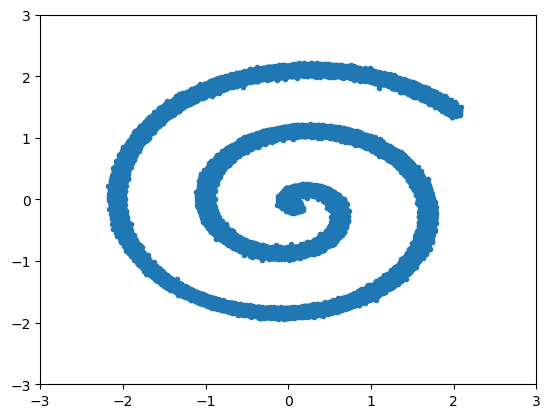

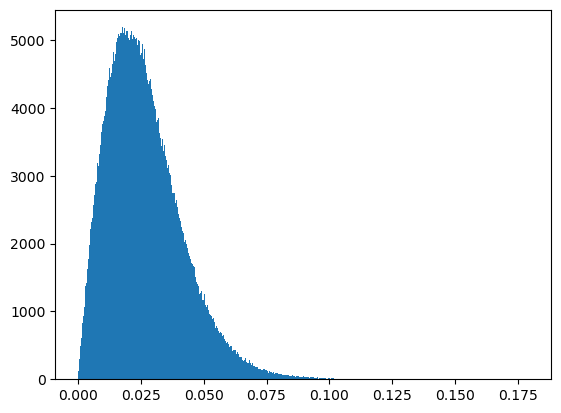

0.026750723
No saved model weights found or Training=True.
training ...
train data length:  4096  last_loss:  0.1949697154632304
training ...
train data length:  4096  last_loss:  0.14615739931468852


Sampling: 100%|██████████| 1000/1000 [07:25<00:00,  2.24iteration/s]


KLD:  0.05989528950170607
Train data size: 4096


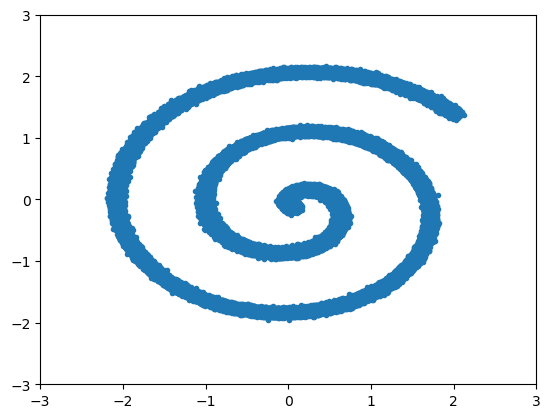

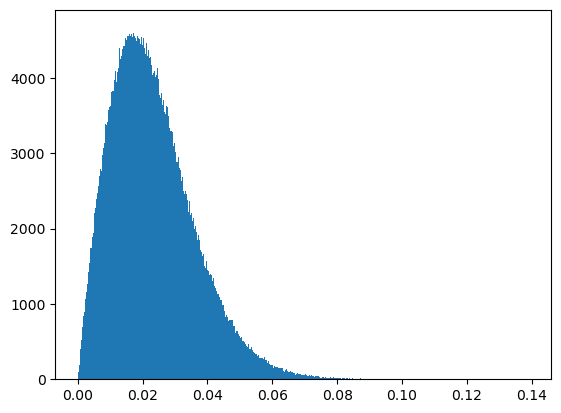

0.023254232
No saved model weights found or Training=True.
training ...
train data length:  8192  last_loss:  0.17197920732724015
training ...
train data length:  8192  last_loss:  0.15866038854437647


Sampling: 100%|██████████| 1000/1000 [07:30<00:00,  2.22iteration/s]


KLD:  0.009579837903675299
Train data size: 8192


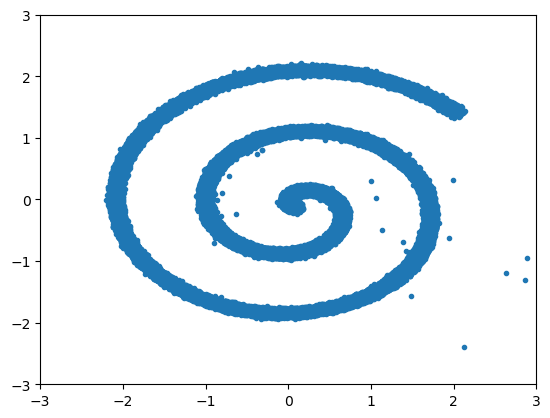

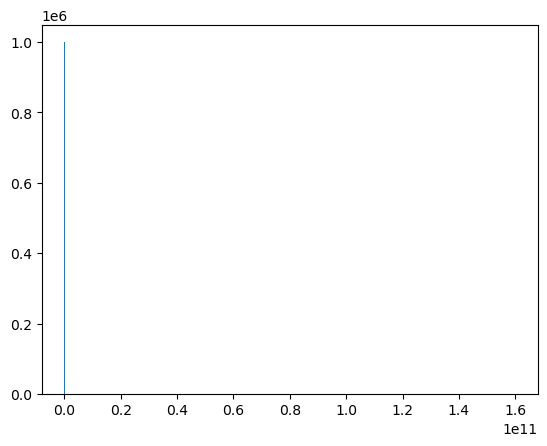

2757562.0


In [3]:
seed_everything(0)
# optimization
learning_rate = 1e-4
num_epochs = 500

beta_min = 1e-4 # for SDE noise [VP]
beta_max = 0.5 # for SDE noise [VP]
cond_scale =1
rescaled_phi = 0

device='cuda'
train_len_vals = np.array([128, 256, 512, 1024, 2048, 4096, 8192])
sample_size = int(1E6)
orig_sample, orig_labels = data_gen(sample_size)
data_mu = torch.mean(orig_sample, dim=0).unsqueeze(0)
data_std = torch.std(orig_sample, dim=0).unsqueeze(0)
orig_sample = (orig_sample - data_mu) / data_std
last_loss_values = []
fid_values = []
avg_nll_values = []
KLD_arr = []
H_gen_arr = []
H_true_arr = []

Training =True

for train_data_length in train_len_vals:
    seed_everything(0)
    train_data, train_labels = data_gen(train_data_length)
    data_mu = torch.mean(train_data, dim=0).unsqueeze(0)
    data_std = torch.std(train_data, dim=0).unsqueeze(0)
    train_data = (train_data - data_mu) / data_std
    #train_data = 2*(train_data-torch.min(train_data, dim=0)[0])/(torch.max(train_data,dim=0)[0]-torch.min(train_data, dim=0)[0])-1
    train_set = [
        (train_data[i], train_labels[i]) for i in range(train_data_length)
    ]
    generator = torch.Generator().manual_seed(0)
    train_set, val_set = torch.utils.data.random_split(train_set, [1,0], generator=generator)

    batch_size = 32
    train_loader = torch.utils.data.DataLoader(
        train_set, batch_size=batch_size
    )

    vp = uncon_VP_1D(beta_min, beta_max)

    model = CtrlCondResNet(2, 2, 1, model_dim=128, dim_mult=[1,1,1,1,1,1], 
                    dim_mult_emb=1, num_blocks=2, dropout=0, 
                    emb_type="sinusoidal", dim_mult_time=1, 
                    dim_mult_cond=1, adaptive_scale=True, skip_scale=1.0, affine=True)

    file_path = f'mdl_weights/ctrl_train_len_{train_data_length}.pth'

    if os.path.exists(file_path) and not Training:
        model.load_state_dict(torch.load(file_path))
        print("Model weights loaded successfully, computing last epoch loss.")
        model.train()
        model.to(device)

        optimizer = torch.optim.Adam(
                model.parameters(),
                lr=learning_rate,
            )
        for epoch in range(num_epochs):
            model.train()
            avg_loss = 0.
            num_items = 0

            for step, batch in enumerate(train_loader):
                x = batch[0]
                c = batch[1]
                x = x.to(device)
                c = c.to(device)
                loss,_ = p_losses_cond(model, vp, x, c)
                
                #optimizer.zero_grad()
                #loss.backward()
                #optimizer.step()
                num_items += x.shape[0]
                avg_loss += loss.item() * x.shape[0]
    else:
        print("No saved model weights found or Training=True.")
        # for training of the uncon model, lock the control net
        for name, param in model.named_parameters():
            if 'ctrl' in name:
                param.requires_grad = False

        model.train()
        model.to(device)

        optimizer = torch.optim.Adam(
                model.parameters(),
                lr=learning_rate,
            )

        global_step = 0
        frames = []
        loss_v = []
        loss_avg = []
        #val_loss_avg = []

        #tqdm_epoch = tqdm.notebook.trange(num_epochs)
        best_val_loss = float('inf')
        save_path = './model.pth' 
        print('training ...')
        for epoch in range(num_epochs):
            model.train()
            avg_loss = 0.
            num_items = 0

            for step, batch in enumerate(train_loader):
                x = batch[0]
                c = batch[1]
                x = x.to(device)
                c = c.to(device)
                loss,_ = p_losses_cond(model, vp, x, c, controlnet=False)
                
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                avg_loss += loss.item() * x.shape[0]
                num_items += x.shape[0]
        print('train data length: ', train_data_length, ' last_loss: ', avg_loss / num_items)

        # for training of the control net, lock the uncon model
        for name, param in model.named_parameters():
            if 'ctrl' in name:
                param.requires_grad = True
            else:
                param.requires_grad = False

        best_val_loss = float('inf')
        save_path = './model.pth' 
        print('training ...')
        optimizer = torch.optim.Adam(
                model.parameters(),
                lr=learning_rate,
            )
        for epoch in range(num_epochs):
            model.train()
            avg_loss = 0.
            num_items = 0

            for step, batch in enumerate(train_loader):
                x = batch[0]
                c = batch[1]
                x = x.to(device)
                c = c.to(device)
                loss,_ = p_losses_cond(model, vp, x, c, controlnet=True)
                
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                avg_loss += loss.item() * x.shape[0]
                num_items += x.shape[0]
                loss_v.append(loss.item())
                loss_avg.append(avg_loss / num_items)
            # Print the averaged training loss so far.
            #if epoch % output_step == 0 or epoch == num_epochs - 1:
        torch.save(model.state_dict(), 'mdl_weights/conctrl_train_len'+'_'+str(train_data_length)+'.pth')
        print('train data length: ', train_data_length, ' last_loss: ', avg_loss / num_items)

    model.eval()
    last_loss = avg_loss / num_items
    vp_sampler = EulerMaruyama(1000, 1e-5, 0, sample_size)
    #vp_ode_sampler = ODE_uncon_EulerMaruyama(1000, 1e-5, 10000, 1e-5, 1e-5)
    test_cond = torch.rand(sample_size, device=device)*10-5
    with torch.no_grad():
        samples, _ = vp_sampler(model, vp, (sample_size, 2),  device, c=test_cond,
                                controlnet=True)
    #samples, _ = vp_ode_sampler(model, vp, train_data.shape, device)
    samples = samples.detach().cpu().numpy()
    fid = fid_metric(samples, orig_sample.detach().cpu().numpy())
    inverse_scaler = 1 # dummy param
    #likelihood_fn = get_likelihood_fn(vp, inverse_scaler)
    #nll = likelihood_fn(model, orig_sample.to(device))[0]
    #avg_nll = np.mean(nll.detach().cpu().numpy())
    '''
    nll_total = 0
    process_batch_size = 100000
    for i in range(0, orig_sample.size(0), process_batch_size):
        batch = orig_sample[i:i + process_batch_size].to(device)  
        batch_nll = likelihood_fn(model, batch)[0]  
        nll_total += batch_nll.sum().item()  
    # Calculate the average NLL
    avg_nll = nll_total / orig_sample.size(0)
    '''
    
    last_loss_values.append(last_loss)
    fid_values.append(fid)
    #avg_nll_values.append(avg_nll)
    kld, H_gen, H_true = get_KLD(samp1=samples, dat=orig_sample.detach().cpu().numpy())
    KLD_arr.append(kld)
    H_gen_arr.append(H_gen)
    H_true_arr.append(H_true)

    print('Train data size:', train_data_length)
    plt.plot(samples[:,0], samples[:,1], ".")
    plt.xlim((-3,3))
    plt.ylim((-3,3))
    plt.show()
    true_pos = get_pos_from_rad(test_cond)
    avg_err = np.mean(np.abs(samples-true_pos), axis=1)
    plt.hist(avg_err, bins=1000)
    plt.show()
    print(np.mean(avg_err))

In [4]:
import pandas as pd

results_df = pd.DataFrame({
    'data_len': train_len_vals,
    'beta_max': np.repeat(beta_max, len(train_len_vals)),
    'last_loss': last_loss_values[-len(train_len_vals):],
    'fid': fid_values[-len(train_len_vals):],
    #'avg_nll': avg_nll_values[-len(train_len_vals):],
    'KLD': KLD_arr[-len(train_len_vals):],
    'H Gen': H_gen_arr[-len(train_len_vals):],
    'H True': H_true_arr[-len(train_len_vals):]
})

print(results_df)

   data_len  beta_max  last_loss           fid       KLD     H Gen    H True
0       128       0.5   0.430493  2.191531e-02  0.953895  1.698995  1.218089
1       256       0.5   0.286602  5.539026e-03  0.717741  1.286290  1.218089
2       512       0.5   0.150322  3.294844e-03  0.387252  1.280219  1.218089
3      1024       0.5   0.170315  1.626174e-03  0.166495  1.201655  1.218089
4      2048       0.5   0.153293  6.806489e-04  0.068236  1.220806  1.218089
5      4096       0.5   0.146157  2.764175e-04  0.059895  1.214836  1.218089
6      8192       0.5   0.158660  5.314232e+17  0.009580  1.214239  1.218089


In [9]:
try:
    model = CtrlCondResNet(2, 2, 1,model_dim=128, dim_mult=[1,1,1,1,1,1], 
                dim_mult_emb=1, num_blocks=2, dropout=0, 
                emb_type="sinusoidal", dim_mult_time=1, 
                dim_mult_cond=1, adaptive_scale=True, skip_scale=1.0, affine=True)
    model.load_state_dict(torch.load('mdl_weights/conctrl_train_len_8192.pth'))
    model = model.to(device)
except:
    pass
model.eval()
last_loss = avg_loss / num_items
vp_sampler = EulerMaruyama(1000, 1e-5, 0, sample_size)
#vp_ode_sampler = ODE_uncon_EulerMaruyama(1000, 1e-5, 10000, 1e-5, 1e-5)
test_sample_size = 10000
test_cond = torch.ones(test_sample_size, device=device)*0
true_pos = get_pos_from_single_rad(test_cond[0].reshape(1,1), data_mu, data_std)
with torch.no_grad():
    samples, _ = vp_sampler(model, vp, (test_sample_size, 2),  device, c=test_cond,
                            controlnet=True)
#samples, _ = vp_ode_sampler(model, vp, train_data.shape, device)
samples = samples.detach().cpu().numpy()
samples_var = np.var(samples, axis=0)
print('Variance in x and y: ', samples_var)
err_arr = samples-true_pos
print('Variance of 2D distribution: ', np.var(np.sum(err_arr,axis=1)))
print('True variance for k=0.03: 0.0018')

Sampling: 100%|██████████| 1000/1000 [00:04<00:00, 231.79iteration/s]

Variance in x and y:  [2.1570592e+17 9.2337057e+13]
Variance of 2D distribution:  2.0686286e+17
True variance for k=0.03: 0.0018
